# Decision Trees

## Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor

## Importing data and preprocessing

In [2]:
df = pd.read_csv("C:/M2SEP/Learning path/MLzoomcamp/data/trees/housing.csv")

In [3]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [4]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
df=df.fillna(0)

In [6]:
df.median_house_value=np.log(df.median_house_value)

## Splitting data in train/val/test

In [39]:
features=df.drop("median_house_value",1).columns
dicts = df[features].to_dict(orient='records')

In [42]:
dv = DictVectorizer(sparse=False)
X = dv.fit_transform(dicts)
Y=df["median_house_value"]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

## Basic decision tree

In [44]:
clf = tree.DecisionTreeRegressor(max_depth=1)
clf = clf.fit(X_train, y_train)

In [45]:
print(export_text(clf,feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



## Basic Random forest

In [46]:
regr = RandomForestRegressor(n_estimators=10, random_state=1)
regr = regr.fit(X_train, y_train)

In [47]:
np.sqrt(mean_squared_error(regr.predict(X_val),y_val))

0.2453588910676007

## Random Forest with hyperparameter tuning

### Choosing best hyperparameter for the n_estimators

In [48]:
rmse_df=pd.DataFrame({"param":np.arange(10,200,10)})
rmse_df['rmse']=np.nan

In [50]:
for i in np.arange(10,200,10):    
    regr = RandomForestRegressor(n_estimators=i, random_state=1,n_jobs=-1)
    regr = regr.fit(X_train, y_train)
    rmse_df.loc[rmse_df.param==i,'rmse']=np.sqrt(mean_squared_error(regr.predict(X_val),y_val))

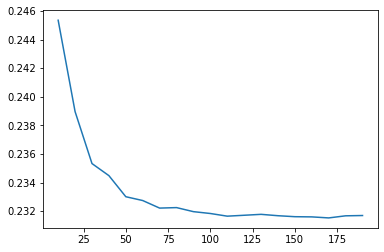

In [51]:
plt.plot(rmse_df.param,rmse_df.rmse)

In [52]:
rmse_df[rmse_df.rmse==rmse_df.rmse.min()]

,param,rmse
16,170,0.23153


### Choosing best hyperparameter for the n_estimators, and max_depth

In [53]:
list_max_depth=[10, 15, 20, 25]
list_n_est=list(np.arange(10,200,10))
rmse_df=pd.DataFrame({"n_est":np.repeat(list_n_est,len(list_max_depth)),"max_depth":list_max_depth*len(list_n_est)})
rmse_df['rmse']=np.nan


In [54]:
for j in list_max_depth:
    for i in list_n_est:    
        regr = RandomForestRegressor(n_estimators=i, random_state=1,max_depth=j,n_jobs=-1)
        regr = regr.fit(X_train, y_train)
        rmse_df.loc[(rmse_df.n_est==i) & (rmse_df.max_depth==j),'rmse']=np.sqrt(mean_squared_error(regr.predict(X_val),y_val))
        

In [55]:
rmse_df[rmse_df.rmse==rmse_df.rmse.min()]

,n_est,max_depth,rmse
67,170,25,0.231696


## Feature Importance

In [13]:
regr = RandomForestRegressor(n_estimators=10, random_state=1,max_depth=20,n_jobs=-1)
regr = regr.fit(X_train, y_train)
regr.feature_importances_

array([1.68877189e-02, 3.29234611e-02, 1.00635995e-01, 9.68727768e-02,
       3.63889951e-01, 3.06679246e-03, 3.10901161e-01, 3.58566277e-04,
       2.70076860e-04, 4.21955925e-03, 3.00099243e-02, 1.90503564e-02,
       2.09136608e-02])

In [16]:
dv.get_feature_names()

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [19]:
import seaborn as sns

<AxesSubplot:>

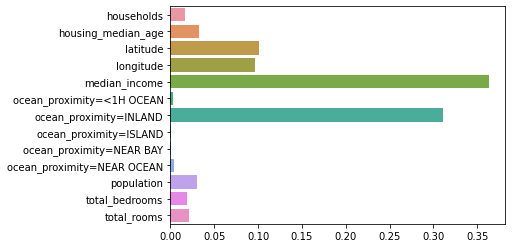

In [20]:
sns.barplot(y=dv.get_feature_names(),x=regr.feature_importances_)

## Xgboost

In [22]:
! pip install xgboost

In [23]:
import xgboost as xgb

In [30]:
[i.replace('<','inf') for i in features]
#features.replace('<','inf')

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=inf1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [32]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=[i.replace('<','inf') for i in features])
dval = xgb.DMatrix(X_val, label=y_val, feature_names=[i.replace('<','inf') for i in features])

In [35]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [34]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

#model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [36]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:8.12733	val-rmse:8.13244
[5]	train-rmse:1.40200	val-rmse:1.40661
[10]	train-rmse:0.34112	val-rmse:0.35698
[15]	train-rmse:0.22977	val-rmse:0.25737
[20]	train-rmse:0.21202	val-rmse:0.24811
[25]	train-rmse:0.20120	val-rmse:0.24347
[30]	train-rmse:0.19298	val-rmse:0.24019
[35]	train-rmse:0.18569	val-rmse:0.23825
[40]	train-rmse:0.17833	val-rmse:0.23687
[45]	train-rmse:0.17270	val-rmse:0.23553
[50]	train-rmse:0.16768	val-rmse:0.23502
[55]	train-rmse:0.16276	val-rmse:0.23384
[60]	train-rmse:0.15875	val-rmse:0.23298
[65]	train-rmse:0.15595	val-rmse:0.23203
[70]	train-rmse:0.15282	val-rmse:0.23180
[75]	train-rmse:0.14970	val-rmse:0.23153
[80]	train-rmse:0.14576	val-rmse:0.23134
[85]	train-rmse:0.14259	val-rmse:0.23069
[90]	train-rmse:0.14056	val-rmse:0.23074
[95]	train-rmse:0.13836	val-rmse:0.23045
[99]	train-rmse:0.13646	val-rmse:0.22983


In [37]:
xgb_params['eta']=0.1

In [38]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:10.44371	val-rmse:10.44937
[5]	train-rmse:6.17511	val-rmse:6.17977
[10]	train-rmse:3.65747	val-rmse:3.66145
[15]	train-rmse:2.17503	val-rmse:2.17860
[20]	train-rmse:1.30614	val-rmse:1.31100
[25]	train-rmse:0.79934	val-rmse:0.80636
[30]	train-rmse:0.51263	val-rmse:0.52326
[35]	train-rmse:0.35799	val-rmse:0.37341
[40]	train-rmse:0.27966	val-rmse:0.30040
[45]	train-rmse:0.24320	val-rmse:0.26777
[50]	train-rmse:0.22558	val-rmse:0.25376
[55]	train-rmse:0.21644	val-rmse:0.24694
[60]	train-rmse:0.21096	val-rmse:0.24312
[65]	train-rmse:0.20606	val-rmse:0.24033
[70]	train-rmse:0.20249	val-rmse:0.23854
[75]	train-rmse:0.19867	val-rmse:0.23702
[80]	train-rmse:0.19484	val-rmse:0.23522
[85]	train-rmse:0.19126	val-rmse:0.23353
[90]	train-rmse:0.18848	val-rmse:0.23265
[95]	train-rmse:0.18459	val-rmse:0.23103
[99]	train-rmse:0.18280	val-rmse:0.23057
